# CA683 Project Group 1: Stock Market Price Trend Prediction
Authors: [Kevin Cogan](mailto:kevin.cogan3@mail.dcu.ie), [Paul Duhamel-Sebline](mailto:paul.duhamelsebline2@mail.dcu.ie), [Christof Kälin](mailto:christof.kalin2@mail.dcu.ie) and [Gonzalo López Gil](mailto:gonzalo.lopezgil2@mail.dcu.ie)


### Idea & Goal

Since Paul and Gonzalo are doing their [practicum](https://gitlab.computing.dcu.ie/lopezgg2/2024-mcm-lopezgg2-duhamep2) together on the prediction of stock market price trends, we decided to go with this topic.

Therefore, we went with a dataset found on Kaggle that has historical data about stocks from January 2000 until today: https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating

Following this, the research question was formulated: Can we forecast the development of the S&P500 using time series models?
// TODO need to make it more precise, e.g. compare models and see which one has the highest monetary gain

### Imports

In [1]:
# Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import requests
from bs4 import BeautifulSoup

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import SimpleRNN, Dropout, Dense
from keras.optimizers import SGD

### Loading the data

In [2]:
# Download the dataset to the Colab environment
!wget https://student.computing.dcu.ie/~kalinc2/ca683/World-Stock-Prices-Dataset.csv

--2024-03-16 19:59:10--  https://student.computing.dcu.ie/~kalinc2/ca683/World-Stock-Prices-Dataset.csv
Resolving student.computing.dcu.ie (student.computing.dcu.ie)... 136.206.218.15
Connecting to student.computing.dcu.ie (student.computing.dcu.ie)|136.206.218.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41042247 (39M) [text/csv]
Saving to: ‘World-Stock-Prices-Dataset.csv’

World-Stock-Prices- 100%[===================>]  39.14M  19.2MB/s    in 2.0s    

2024-03-16 19:59:13 (19.2 MB/s) - ‘World-Stock-Prices-Dataset.csv’ saved [41042247/41042247]



In [3]:
#Read the CSV file
df = pd.read_csv('World-Stock-Prices-Dataset.csv')

## Pre-Processing & EDA


### Data Pre-Processing

**Analyse Missing Values**

In [4]:
# Analyzing missing values
def analyze_missing_values(dataframe):
    # Count total missing and sort it
    total = dataframe.isnull().sum().sort_values(ascending=False)

    # Calculate percentage
    percent = (dataframe.isnull().sum() / dataframe.isnull().count() * 100).sort_values(ascending=False)

    # Concatenate total and percent into a DataFrame
    missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])

    # Exclude columns that do not have any missing values
    missing_data = missing_data[missing_data['Total Missing'] > 0]

    return missing_data

# Get the missing values data
missing_values_data = analyze_missing_values(df)

print(missing_values_data)

Empty DataFrame
Columns: [Total Missing, Percent]
Index: []


**Parsing Dates**

In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

**Numerical Correction**

In [6]:
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

**Handle Missing Data**

In [7]:
df.dropna(inplace=True)

**Standardising Text**

In [8]:
text_columns = ['Brand_Name', 'Ticker', 'Industry_Tag', 'Country']
for col in text_columns:
    df[col] = df[col].str.lower()

**Remove Whitespaces**

In [9]:
text_columns = ['Brand_Name', 'Ticker', 'Industry_Tag', 'Country']
for col in text_columns:
    df[col] = df[col].str.strip()

### Exploratory Data Analysis

In [10]:
# Summary statistics for numerical columns
summary_statistics = df.describe()

# Count of unique values in categorical columns
unique_brands = df['Brand_Name'].nunique()
unique_tickers = df['Ticker'].nunique()
unique_industries = df['Industry_Tag'].nunique()
unique_countries = df['Country'].nunique()

# Convert dates to datetime for any time series analysis
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Earliest and latest date in the dataset to understand the time range
earliest_date = df['Date'].min()
latest_date = df['Date'].max()

summary_statistics, unique_brands, unique_tickers, unique_industries, unique_countries, earliest_date, latest_date

(                Open           High            Low          Close  \
 count  279753.000000  279753.000000  279753.000000  279753.000000   
 mean       65.162445      65.914283      64.389596      65.167955   
 std       117.203158     118.573147     115.772027     117.190963   
 min         0.196890       0.199922       0.192798       0.198861   
 25%        15.049936      15.253301      14.837500      15.050000   
 50%        32.329837      32.712338      31.923977      32.330002   
 75%        72.318681      72.980003      71.635438      72.348923   
 max      2165.010010    2175.010010    2138.050049    2153.199951   
 
              Volume      Dividends   Stock Splits  
 count  2.797530e+05  279753.000000  279753.000000  
 mean   2.349103e+07       0.003406       0.000751  
 std    8.864361e+07       0.062041       0.073979  
 min    0.000000e+00       0.000000       0.000000  
 25%    1.350600e+06       0.000000       0.000000  
 50%    4.630800e+06       0.000000       0.000000

### Graph Analysis

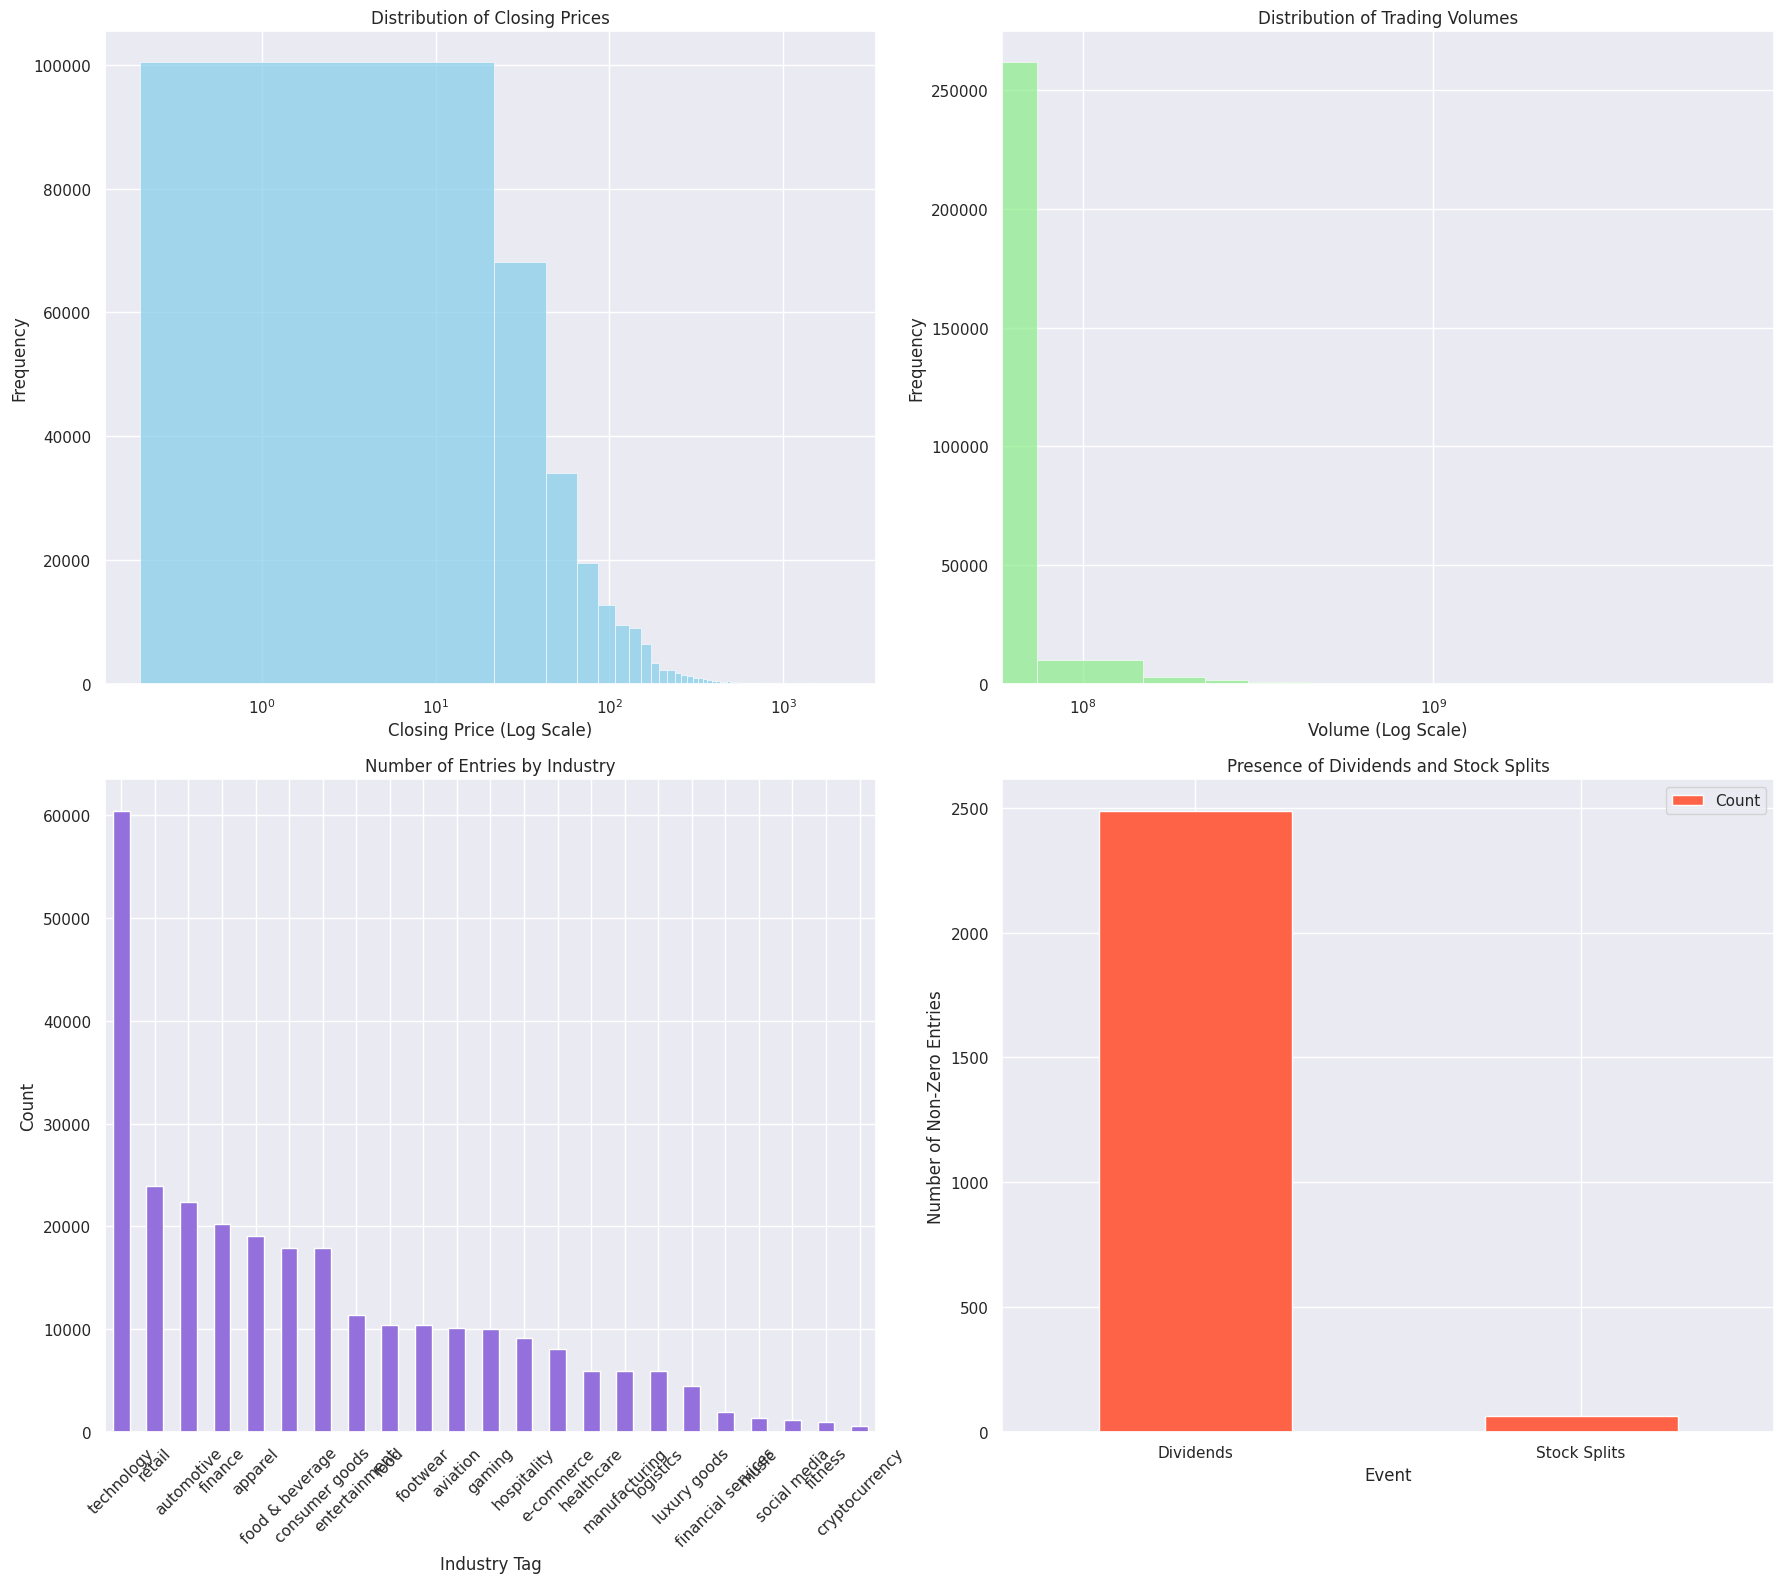

In [11]:
# Preparing data for plotting
# Distribution of Closing Prices
closing_prices = df['Close']

# Distribution of Volumes
volumes = df['Volume']

# Dividends and Stock Splits
dividends = df['Dividends']
stock_splits = df['Stock Splits']

# Industry representation
industry_counts = df['Industry_Tag'].value_counts()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# Distribution of Closing Prices
sns.histplot(closing_prices, bins=100, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Closing Prices')
axes[0, 0].set_xscale('log')
axes[0, 0].set_xlabel('Closing Price (Log Scale)')
axes[0, 0].set_ylabel('Frequency')

# Distribution of Volumes
sns.histplot(volumes, bins=100, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribution of Trading Volumes')
axes[0, 1].set_xscale('log')
axes[0, 1].set_xlabel('Volume (Log Scale)')
axes[0, 1].set_ylabel('Frequency')

# Industry Representation
industry_counts.plot(kind='bar', ax=axes[1, 0], color='mediumpurple')
axes[1, 0].set_title('Number of Entries by Industry')
axes[1, 0].set_xlabel('Industry Tag')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Dividends and Stock Splits Presence
dividends_non_zero = dividends[dividends > 0].count()
stock_splits_non_zero = stock_splits[stock_splits > 0].count()
presence_data = {'Event': ['Dividends', 'Stock Splits'], 'Count': [dividends_non_zero, stock_splits_non_zero]}

presence_df = pd.DataFrame(presence_data)
presence_df.plot(kind='bar', x='Event', y='Count', ax=axes[1, 1], color='tomato')
axes[1, 1].set_title('Presence of Dividends and Stock Splits')
axes[1, 1].set_ylabel('Number of Non-Zero Entries')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

1. Distribution of Closing Prices: This histogram shows the frequency distribution of closing prices on a logarithmic scale, highlighting the wide range of stock prices in the dataset. The log scale helps to better visualize the distribution across a broad range of values.

2. Distribution of Trading Volumes: Similar to the closing prices, this histogram uses a logarithmic scale to display the trading volumes, illustrating the varied trading activity across different stocks. The log scale is crucial for managing the wide disparity in volumes.

3. Number of Entries by Industry: The bar chart presents the count of dataset entries categorized by industry, showcasing which sectors are more prevalent. This visualization helps identify the industries with the highest representation in the dataset.

4. Presence of Dividends and Stock Splits: This bar chart shows the number of non-zero entries for dividends and stock splits, offering insight into how often these events occur within the dataset. It highlights the relative rarity of dividends and stock splits compared to the total number of entries.

**Effect of COVID on the Stock Market**

In [12]:
# Filtering the dataset for pre-COVID and post-COVID periods

# Assuming the dataset uses UTC time zone
pre_covid_end_date = pd.to_datetime('2020-03-01', utc=True)

# Now perform the comparison with datetime objects
pre_covid_df = df[df['Date'] < pre_covid_end_date]
post_covid_df = df[df['Date'] >= pre_covid_end_date]


# Aggregating data for each industry for pre-COVID and post-COVID periods
# Focus on average closing price and average volume as key metrics
pre_covid_agg = pre_covid_df.groupby('Industry_Tag').agg({
    'Close': 'mean',
    'Volume': 'mean'
}).reset_index().rename(columns={'Close': 'Pre-COVID Avg Close', 'Volume': 'Pre-COVID Avg Volume'})

post_covid_agg = post_covid_df.groupby('Industry_Tag').agg({
    'Close': 'mean',
    'Volume': 'mean'
}).reset_index().rename(columns={'Close': 'Post-COVID Avg Close', 'Volume': 'Post-COVID Avg Volume'})

# Merging the pre-COVID and post-COVID aggregated data for comparison
covid_impact = pd.merge(pre_covid_agg, post_covid_agg, on='Industry_Tag')

# Calculating the percentage change in average close price and volume
covid_impact['% Change in Avg Close'] = ((covid_impact['Post-COVID Avg Close'] - covid_impact['Pre-COVID Avg Close']) / covid_impact['Pre-COVID Avg Close']) * 100
covid_impact['% Change in Avg Volume'] = ((covid_impact['Post-COVID Avg Volume'] - covid_impact['Pre-COVID Avg Volume']) / covid_impact['Pre-COVID Avg Volume']) * 100

# Sorting by percentage change in average close price for visualization
covid_impact_sorted = covid_impact.sort_values(by='% Change in Avg Close', ascending=False)

covid_impact_sorted

,Industry_Tag,Pre-COVID Avg Close,Pre-COVID Avg Volume,Post-COVID Avg Close,Post-COVID Avg Volume,% Change in Avg Close,% Change in Avg Volume
4,e-commerce,17.652308,1.085048e+08,110.784646,4.908077e+07,527.592973,-54.766290
21,technology,27.361623,8.041658e+07,146.008830,2.700934e+07,433.626355,-66.413215
9,food,176.798153,3.833901e+06,865.779306,1.681578e+06,389.699293,-56.139237
5,entertainment,59.393701,1.325956e+07,275.996837,9.944299e+06,364.690419,-25.002823
16,luxury goods,30.389511,8.772549e+04,134.764982,1.690802e+05,343.458874,92.737808
19,retail,51.801582,5.442443e+06,228.962307,4.258884e+06,341.998675,-21.746824
12,gaming,5.923236,7.616899e+05,22.954044,5.083457e+06,287.525365,567.391915
6,finance,54.831941,1.439898e+07,205.352646,7.601189e+06,274.512816,-47.210215
10,food & beverage,32.509878,1.027200e+07,110.617382,8.208524e+06,240.257758,-20.088385
7,financial services,42.163135,9.038891e+06,134.281793,1.271486e+07,218.481520,40.668351


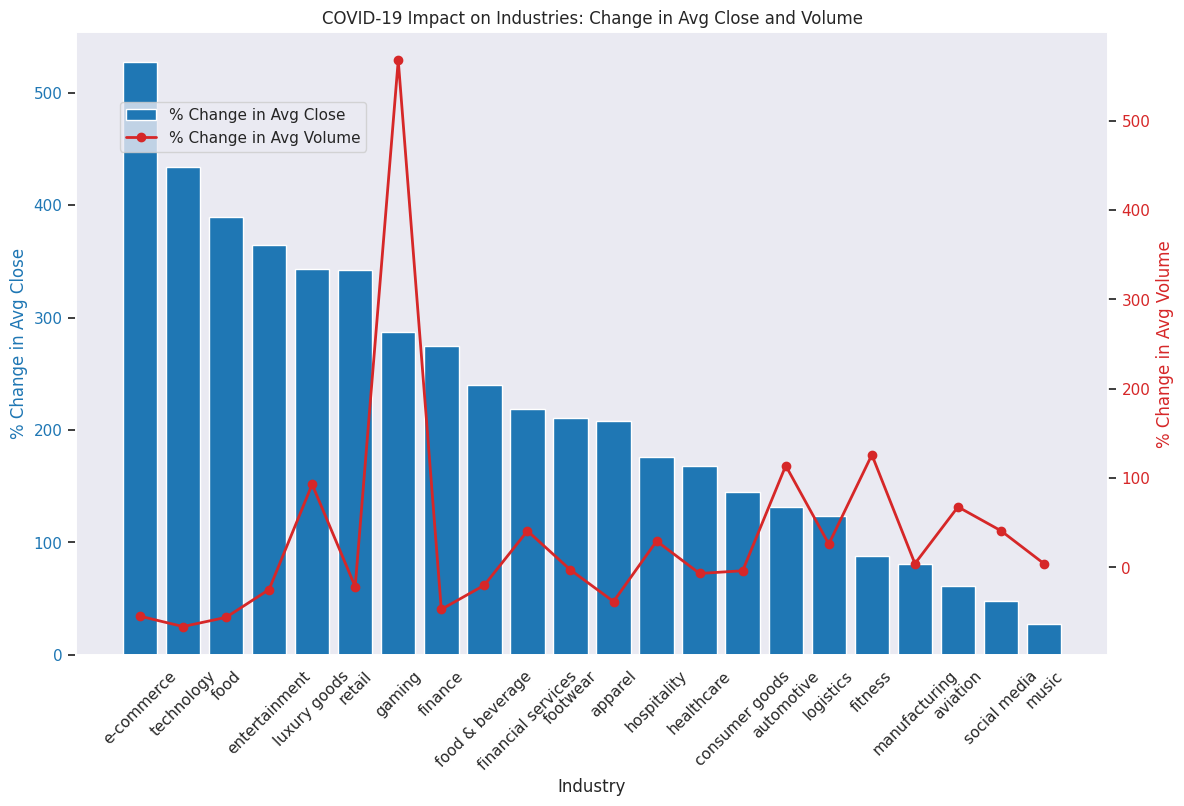

In [13]:
# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('Industry')
ax1.set_ylabel('% Change in Avg Close', color=color)
ax1.bar(covid_impact_sorted['Industry_Tag'], covid_impact_sorted['% Change in Avg Close'], color=color, label='% Change in Avg Close')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(False)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('% Change in Avg Volume', color=color)
ax2.plot(covid_impact_sorted['Industry_Tag'], covid_impact_sorted['% Change in Avg Volume'], color=color, marker='o', label='% Change in Avg Volume', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title('COVID-19 Impact on Industries: Change in Avg Close and Volume')
plt.show()

### Feature Engineering
As we learnt about feature engineering and enriching data current columns and web scraping, we decided to evaluate which companies are in the *current* S&P 500 index fund. The source used to scrape is Wikipedia.

In [14]:
# Get a list of companies in the S&P 500 index
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', id='constituents')

company_names = []
for row in table.find_all('tr')[1:]:  # Skip header row
    cells = row.find_all('td')
    company_names.append(cells[0].text.strip().lower())

In [15]:
# Add them to the dataframe
df['SP500'] = df['Ticker'].apply(lambda x: x in company_names)

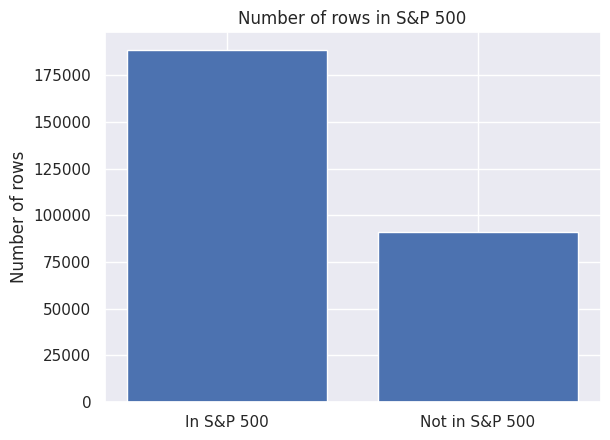

In [16]:
# Plot bars
plt.bar(['In S&P 500', 'Not in S&P 500'], [df['SP500'].value_counts()[True], df['SP500'].value_counts()[False]], label='Count')

# Set labels and title
plt.ylabel('Number of rows')
plt.title('Number of rows in S&P 500')

# Show plot
plt.show()

## Time Series

Out of this index we are creating a time series by summing up the Close prices from each day. \
We then derive two more times series: On a monthly and on a quarterly basis.

In [17]:
ts = df.loc[df['SP500'] ==True].groupby('Date')['Close'].sum().reset_index()

In [18]:
ts = ts[:5911] # Drop after June 2023

In [19]:
# Training group until 2021
ts_train = ts[:5536]
ts_test = ts[5536:]

<Axes: xlabel='Date'>

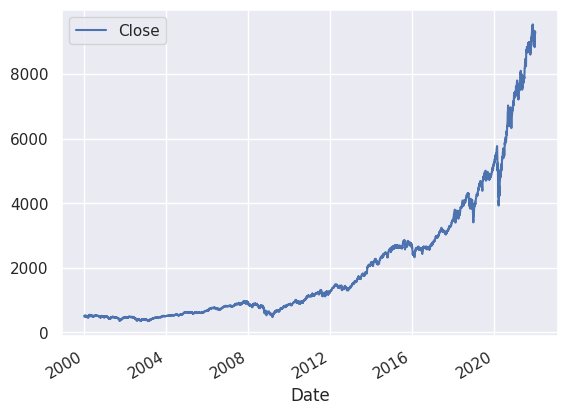

In [20]:
ts_train.plot.line(x='Date', y='Close')

### Smoothing: Exponential Moving Averages

In [21]:
# Calculate the 50 and 200-day EMA for AAPL's closing price
ts_ema = ts_train
ts_ema['50-day EMA'] = ts_ema['Close'].ewm(span=50, adjust=False).mean()
ts_ema['200-day EMA'] = ts_ema['Close'].ewm(span=200, adjust=False).mean()

ts_ema.tail()  # Most recent EMA values

<ipython-input-21-2dc1631214c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_ema['50-day EMA'] = ts_ema['Close'].ewm(span=50, adjust=False).mean()
<ipython-input-21-2dc1631214c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_ema['200-day EMA'] = ts_ema['Close'].ewm(span=200, adjust=False).mean()


,Date,Close,50-day EMA,200-day EMA
5531,2021-12-27 05:00:00+00:00,9321.816479,9122.442445,8523.567095
5532,2021-12-28 05:00:00+00:00,9293.714481,9129.158995,8531.230253
5533,2021-12-29 05:00:00+00:00,9295.499088,9135.682136,8538.834918
5534,2021-12-30 05:00:00+00:00,9275.912769,9141.181377,8546.169026
5535,2021-12-31 05:00:00+00:00,9253.810799,9145.598217,8553.210238


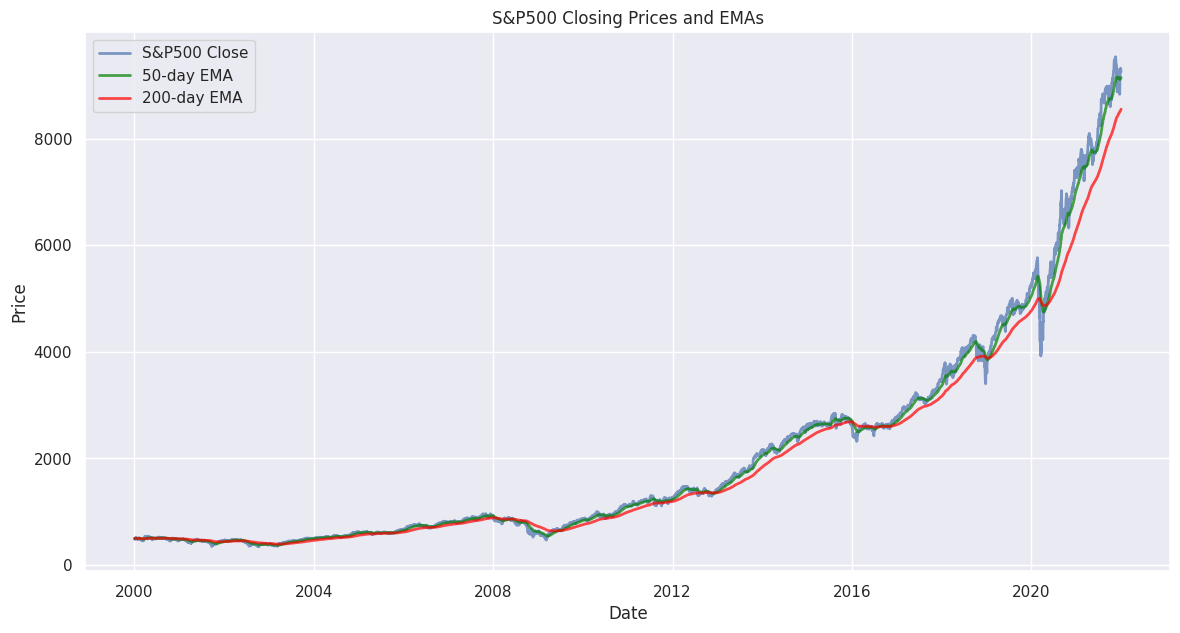

In [22]:
# Set the figure size
plt.figure(figsize=(14, 7))

# Plot the closing prices
plt.plot(ts_ema['Date'], ts_ema['Close'], label='S&P500 Close', linewidth=2, alpha=0.7)

# Plot all the EMAs
plt.plot(ts_ema['Date'], ts_ema['50-day EMA'], label='50-day EMA', linewidth=2, alpha=0.7, color='green')
plt.plot(ts_ema['Date'], ts_ema['200-day EMA'], label='200-day EMA', linewidth=2, alpha=0.7, color='red')

# Adding titles and labels
plt.title('S&P500 Closing Prices and EMAs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()

### Prediction: Recurrent Neural Network

#### Normalization

In [23]:
# Selecting the Close Values
rnn_train = ts_train['Close'].values
# Reshaping 1D to 2D array
rnn_train = np.reshape(rnn_train, (-1,1))
rnn_train.shape

(5536, 1)

In [24]:
scaler = MinMaxScaler(feature_range=(0,1))
rnn_train_scaled = scaler.fit_transform(rnn_train)

print(rnn_train_scaled[:5])

[[0.01687521]
 [0.01502195]
 [0.01531349]
 [0.01585425]
 [0.01768698]]


In [25]:
# Repeat for test
rnn_test = ts_test['Close'].values
rnn_test = np.reshape(rnn_test, (-1,1))
rnn_test_scaled = scaler.fit_transform(rnn_test)

#### Divide into X and y and reshape

In [26]:
X_train = []
y_train = []
for i in range(50, len(rnn_train_scaled)):
    X_train.append(rnn_train_scaled[i-50:i, 0])
    y_train.append(rnn_train_scaled[i, 0])
    if i <= 51:
        print(X_train)
        print(y_train)
        print()

[array([0.01687521, 0.01502195, 0.01531349, 0.01585425, 0.01768698,
       0.01839708, 0.0178667 , 0.01747937, 0.01828096, 0.01873243,
       0.01832719, 0.01839222, 0.01765268, 0.01666659, 0.01529384,
       0.016349  , 0.016283  , 0.01626067, 0.01452   , 0.01576158,
       0.01696566, 0.01676623, 0.01737082, 0.01730843, 0.01731967,
       0.01841976, 0.01770482, 0.01770144, 0.01722132, 0.01645803,
       0.0167818 , 0.01635093, 0.01571541, 0.01462849, 0.0142797 ,
       0.01494785, 0.01404292, 0.01297305, 0.01390385, 0.01455934,
       0.01443166, 0.01382992, 0.01513436, 0.01436396, 0.01230444,
       0.01229699, 0.01347889, 0.01277632, 0.01258724, 0.01182804])]
[0.014203856056834843]

[array([0.01687521, 0.01502195, 0.01531349, 0.01585425, 0.01768698,
       0.01839708, 0.0178667 , 0.01747937, 0.01828096, 0.01873243,
       0.01832719, 0.01839222, 0.01765268, 0.01666659, 0.01529384,
       0.016349  , 0.016283  , 0.01626067, 0.01452   , 0.01576158,
       0.01696566, 0.01676623, 0.0

In [27]:
X_test = []
y_test = []
for i in range(50, len(rnn_test_scaled)):
    X_test.append(rnn_test_scaled[i-50:i, 0])
    y_test.append(rnn_test_scaled[i, 0])

In [28]:
# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print('X_train:', X_train.shape, '// y_train:', y_train.shape)

X_train: (5486, 50, 1) // y_train: (5486, 1)


In [29]:
# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)

#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print('X_test :', X_test.shape, '// y_test :', y_test.shape)

X_test : (325, 50, 1) // y_test : (325, 1)


#### RNN model

Code from here: https://www.geeksforgeeks.org/time-series-forecasting-using-recurrent-neural-networks-rnn-in-tensorflow/

In [30]:
"""
# Initliaze the RNN
regressor = Sequential()

# Add RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = 'tanh',
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
                        activation = 'tanh',
                        return_sequences = True))

regressor.add(SimpleRNN(units = 50,
                        activation = 'tanh',
                        return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# Add output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# Comple RNN
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = 'mean_squared_error')

# Fit the model
regressor.fit(X_train, y_train, epochs = 20, batch_size = 2)
regressor.summary()

# Save trained model
regressor.save('regressor.keras')
"""

"\n# Initliaze the RNN\nregressor = Sequential()\n \n# Add RNN layers and dropout regularization\nregressor.add(SimpleRNN(units = 50, \n                        activation = 'tanh',\n                        return_sequences = True,\n                        input_shape = (X_train.shape[1],1)))\nregressor.add(Dropout(0.2))\n \nregressor.add(SimpleRNN(units = 50, \n                        activation = 'tanh',\n                        return_sequences = True))\n \nregressor.add(SimpleRNN(units = 50,\n                        activation = 'tanh',\n                        return_sequences = True))\n \nregressor.add( SimpleRNN(units = 50))\n \n# Add output layer\nregressor.add(Dense(units = 1,activation='sigmoid'))\n \n# Comple RNN\nregressor.compile(optimizer = SGD(learning_rate=0.01,\n                                  momentum=0.9, \n                                  nesterov=True), \n                  loss = 'mean_squared_error')\n \n# Fit the model\nregressor.fit(X_train, y_train, epochs = 

#### Prediction

In [31]:
# Download the trained model
!wget https://student.computing.dcu.ie/~kalinc2/ca683/regressor.keras

--2024-03-16 19:59:49--  https://student.computing.dcu.ie/~kalinc2/ca683/regressor.keras
Resolving student.computing.dcu.ie (student.computing.dcu.ie)... 136.206.218.15
Connecting to student.computing.dcu.ie (student.computing.dcu.ie)|136.206.218.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185586 (181K)
Saving to: ‘regressor.keras’

regressor.keras     100%[===================>] 181.24K   627KB/s    in 0.3s    

2024-03-16 19:59:50 (627 KB/s) - ‘regressor.keras’ saved [185586/185586]



In [32]:
regressor = load_model('regressor.keras')

In [33]:
y_RNN = scaler.inverse_transform(regressor.predict(X_test))

11/11 [==============================] - 1s 15ms/step


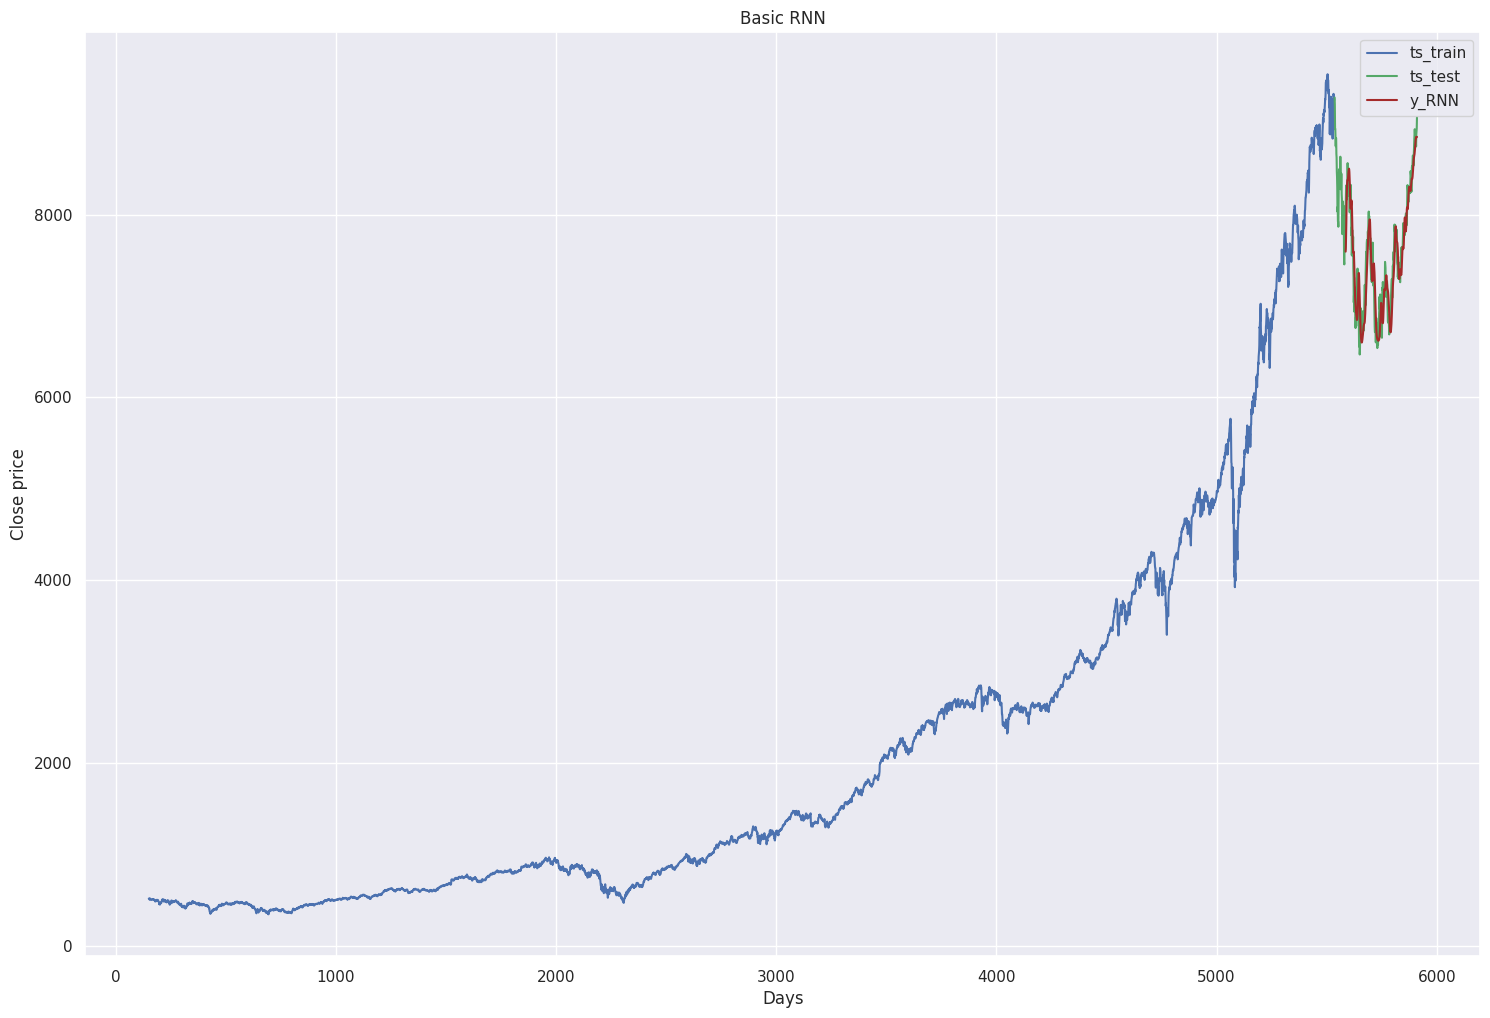

In [34]:
# Plot for RNN predictions
plt.figure(figsize=(18, 12))
plt.plot(ts_train.index[150:], ts_train['Close'].values[150:], label='ts_train', color='b')
plt.plot(ts_test.index, ts_test['Close'].values, label='ts_test', color='g')
plt.plot(ts_test.index[50:], y_RNN, label='y_RNN', color='brown')
plt.legend()
plt.title('Basic RNN')

plt.xlabel('Days')
plt.ylabel('Close price')

plt.show()